In [23]:
import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px  # for color sequences

def generate_spidergraph(data_path: str):
    """
    Generate a spider (radar) chart comparing multiple models' accuracies across languages.
    
    Args:
        data_path (str): Path to input CSV file.
        output_folder (str): Directory where to save the resulting plot.
    """
    # Read and prepare data
    df = pd.read_csv(data_path)
    df = df[df['level'] != 'Overall']  # Remove overall score
    
    # Extract languages and models
    languages = df['level'].tolist()
    models = [col for col in df.columns if col != 'level']
    
    # Close the loop for languages by appending the first language at the end.
    languages_closed = languages + [languages[0]]
    
    # Create Plotly figure
    fig = go.Figure()
    
    # Use Plotly's default qualitative color sequence (or choose your own)
    color_sequence = px.colors.qualitative.Plotly
    
    # Add a trace for each model
    for i, model in enumerate(models):
        values = df[model].tolist()
        # Close the loop by appending the first value again
        values_closed = values + [values[0]]
        
        fig.add_trace(go.Scatterpolar(
            r=values_closed,
            theta=languages_closed,
            mode='lines+markers',
            name=model,
            line=dict(color=color_sequence[i % len(color_sequence)], width=2),
            fill='toself',
            # Using the same color for the fill with some transparency:
            fillcolor=color_sequence[i % len(color_sequence)],
            opacity=0.5  # Adjust opacity of the trace if needed
        ))
    
    # Update layout similar to the Matplotlib settings
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1],
                tickvals=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
                ticktext=["0%", "20%", "40%", "60%", "80%", "100%"],
                # Optionally, you can adjust tick font
                tickfont=dict(size=10, color="grey")
            ),
            angularaxis=dict(
                tickfont=dict(size=14, color="black"),
                rotation=90,         # Sets the starting angle (equivalent to pi/2 offset)
                direction="clockwise"  # Reverse direction to mimic Matplotlib's '-1'
            ),
        ),
        legend=dict(
        font=dict(size=14),
        orientation="h",  # Horizontal legend
        yanchor="bottom",
        y=1.1,  # Adjust height of legend above the graph
        xanchor="center",
        x=0.5
    ),
    margin=dict(l=50, r=50, t=50, b=50)  # Reduced top margin
    )
    
    # Optionally display the figure in your browser or notebook
    fig.show()

# Example usage:
generate_spidergraph("eval_results/results_accuracy/accuracy_across_level.csv")

In [20]:
def plot_stacked_bar(file_path):
    """
    Reads a CSV file with exam questions, groups the data by language and level,
    and displays a stacked bar plot where each language shows the distribution of question levels.
    
    Parameters:
        file_path (str): Path to the CSV file containing at least 'language' and 'level' columns.
    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    if 'Overall' in df['language'].values:
        df = df[df['language'] != 'Overall']
    
    # Transform the DataFrame from wide to long format
    df_long = df.melt(id_vars=['language'], 
                      var_name='Exam Subject', 
                      value_name='Count')
    
    # Create a stacked bar plot using Plotly Express
    fig = px.bar(
        df_long,
        x='language',
        y='Count',
        color='Exam Subject',
        barmode='stack',
        labels={'language': 'Language'}
    )
    
    # Show the figure
    fig.show()

# Example usage:
plot_stacked_bar("eval_results\statistics\category_en_per_language.csv")

In [28]:
from eval_utils import LANGUAGES
def plot_image_counts(file_path):
    """
    Reads a JSON file containing exam questions, counts how many have images and how many do not,
    and creates a grouped bar plot per language.

    The JSON file must have at least:
       - 'language': The language of the question.
       - 'image_png': A string (or similar) with image data, or null if the question has no image.

    Parameters:
        file_path (str): Path to the JSON file.
    """
    # Read the JSON file into a DataFrame
    df = pd.read_json(file_path)
    
    # Ensure required columns exist
    if not {'language', 'image_png'}.issubset(df.columns):
        raise ValueError("The JSON file must contain 'language' and 'image_png' columns.")
    
    df['language'] = df['language'].apply(lambda code: LANGUAGES.get(code, code))
    # Create a new column to classify questions
    df['has_image'] = df['image_png'].notnull().map({True: 'With Image', False: 'Text Only'})
    
    # Count the number of questions per language and image category
    grouped = df.groupby(['language', 'has_image']).size().reset_index(name='count')
    
    # Create the grouped bar plot
    fig = px.bar(
        grouped,
        x='language',
        y='count',
        color='has_image',
        barmode='group',  
        labels={
            'language': 'Language',
            'count': 'Number of Questions',
            'has_image': 'Question Type'
        }
    )
    
    # Show the plot
    fig.show()

# Example usage:
plot_image_counts("eval_results\inference_results.json")

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def generate_spidergraph(data_path: str, output_folder: str):
    """
    Generate a spider (radar) chart comparing multiple models' accuracies across languages.
    
    Args:
        data_path (str): Path to input CSV file.
        output_folder (str): Directory where to save the resulting plot.
    """
    # Read and prepare data
    df = pd.read_csv(data_path)
    df = df[df['language'] != 'Overall']  # Remove overall score
    
    # Extract languages and models
    languages = df['language'].tolist()
    models = [col for col in df.columns if col != 'language']
    num_vars = len(languages)
    
    # Calculate angles for radar chart
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Close the circle
    
    # Create figure and polar axis
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
    
    # Configure polar plot settings
    ax.set_theta_direction(-1)  # Clockwise direction
    ax.set_theta_offset(np.pi/2)  # Start at top
    ax.set_rlim(0, 1)
    ax.set_rticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'], 
                      fontsize=10, color='grey')
    ax.grid(color='grey', linestyle='--', linewidth=0.5)
    
    # Set angular axis labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(languages, fontsize=14, color='black')
    
    # Use Matplotlib's color cycle
    colors = plt.cm.tab10.colors
    
    # Plot each model's data
    for i, model in enumerate(models):
        values = df[model].tolist()
        values += values[:1]  # Close the data loop
        color = colors[i % len(colors)]
        
        ax.plot(angles, values, color=color, linewidth=2, 
               marker='o', markersize=4, label=model)
        ax.fill(angles, values, color=color, alpha=0.5)
    
    # Configure legend
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
             ncol=len(models), fontsize=14, frameon=False)
    
    # Save and close figure
    plt.tight_layout()
    plt.savefig(f"{output_folder}/accuracy_language_spider.png", bbox_inches='tight')
    plt.close()

# Example usage:
generate_spidergraph("eval_results/results_accuracy/accuracy_across_language.csv", "eval_results/plots")

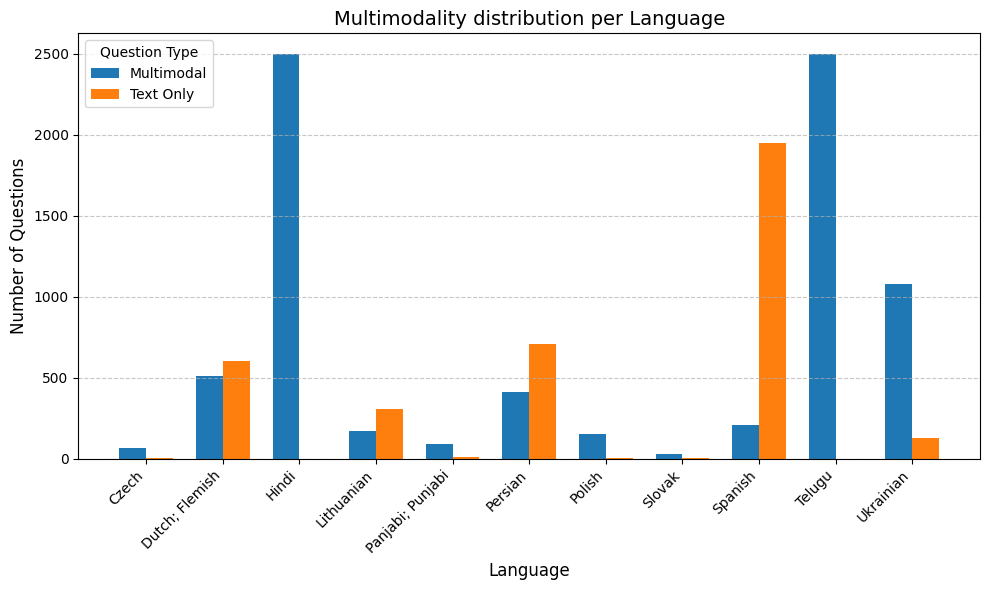

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from eval_utils import LANGUAGES

def plot_image_counts(file_path: str):
    """
    Reads a JSON file containing exam questions, counts how many have images and how many do not,
    and creates a grouped bar plot per language.

    The JSON file must have at least:
       - 'language': The language of the question.
       - 'image_png': A string (or similar) with image data, or null if the question has no image.

    Parameters:
        file_path (str): Path to the JSON file.
    """
    # Read the JSON file into a DataFrame
    df = pd.read_json(file_path)
    
    # Ensure required columns exist
    if not {'language', 'image_png'}.issubset(df.columns):
        raise ValueError("The JSON file must contain 'language' and 'image_png' columns.")
    
    # Map language codes to full names (assuming LANGUAGES is defined elsewhere)
    df['language'] = df['language'].apply(lambda code: LANGUAGES.get(code, code))
    
    # Create a new column to classify questions
    df['has_image'] = df['image_png'].notnull().map({True: 'Multimodal', False: 'Text Only'})
    
    # Count the number of questions per language and image category
    grouped = df.groupby(['language', 'has_image']).size().reset_index(name='count')
    
    # Pivot the data for grouped bar plotting
    pivot_df = grouped.pivot(index='language', columns='has_image', values='count')
    
    # Create the grouped bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Define positions for the bars
    bar_width = 0.35
    x = range(len(pivot_df.index))
    
    # Plot bars for each category
    for i, (category, counts) in enumerate(pivot_df.items()):
        ax.bar([pos + i * bar_width for pos in x], counts, width=bar_width, label=category)
    
    # Customize the plot
    ax.set_xlabel('Language', fontsize=12)
    ax.set_ylabel('Number of Questions', fontsize=12)
    ax.set_title('Multimodality distribution per Language', fontsize=14)
    ax.set_xticks([pos + bar_width / 2 for pos in x])
    ax.set_xticklabels(pivot_df.index, rotation=45, ha='right', fontsize=10)
    ax.legend(title='Question Type', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Example usage:
plot_image_counts("eval_results/inference_results_cleaned.json")

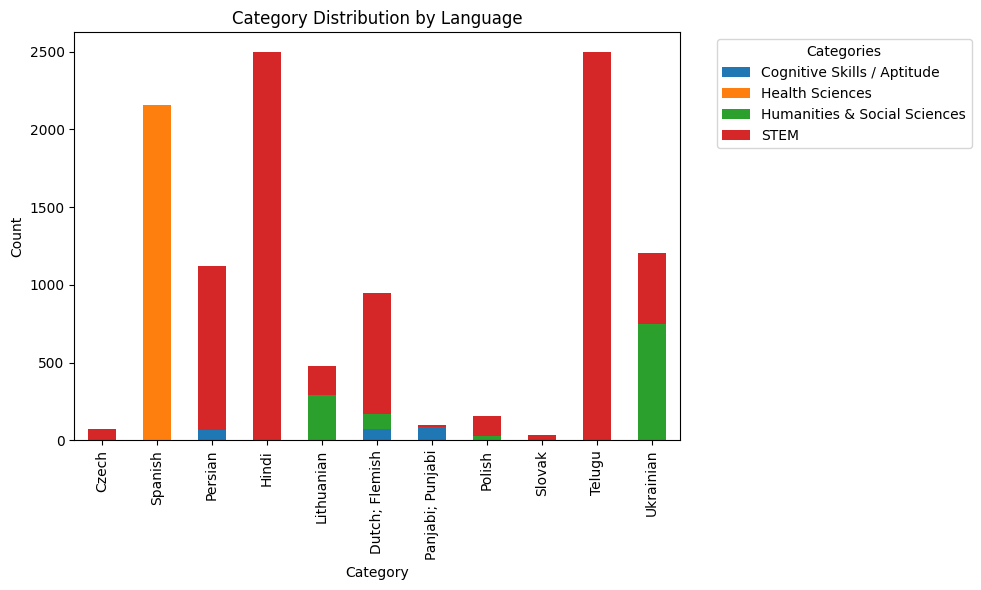

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_stacked_bar(file_path):
    """
    Reads a CSV file with exam questions, groups the data by language and exam subject,
    and displays a stacked bar plot where each language shows the distribution of exam subjects.
    
    The CSV is expected to have at least a 'language' column, with all other columns representing 
    counts for different exam subjects.
    
    Parameters:
        file_path (str): Path to the CSV file.
    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Exclude rows where language is 'Overall' (if present)
    if 'Overall' in df['language'].values:
        df = df[df['language'] != 'Overall']
    
    # Assume that all columns except 'language' are exam subjects.
    # Set 'language' as the index and use the remaining columns for the bar plot.
    exam_subjects = [col for col in df.columns if col != 'language']
    df_pivot = df.set_index('language')[exam_subjects]
    
    # Create a stacked bar plot
    ax = df_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
    
    # Set plot labels and title
    ax.set_xlabel('Category')
    ax.set_ylabel('Count')
    ax.set_title('Category Distribution by Language')
    plt.legend(title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout for readability and display the plot
    plt.tight_layout()
    plt.show()

# Example usage:
plot_stacked_bar("eval_results\statistics\category_en_per_language.csv")

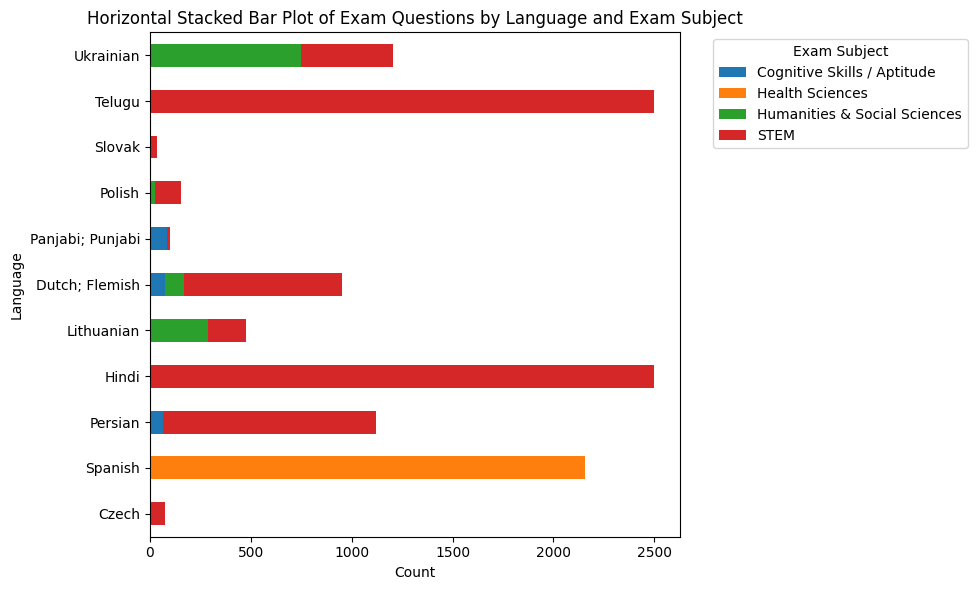

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_stacked_bar(file_path):
    """
    Reads a CSV file with exam questions, groups the data by language and exam subject,
    and displays a horizontal stacked bar plot where each language shows the distribution
    of exam subjects (counts along the x-axis).
    
    The CSV is expected to have at least a 'language' column, with all other columns representing 
    counts for different exam subjects.
    
    Parameters:
        file_path (str): Path to the CSV file.
    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Exclude rows where language is 'Overall' (if present)
    if 'Overall' in df['language'].values:
        df = df[df['language'] != 'Overall']
    
    # Assume that all columns except 'language' are exam subjects.
    exam_subjects = [col for col in df.columns if col != 'language']
    df_pivot = df.set_index('language')[exam_subjects]
    
    # Create a horizontal stacked bar plot
    ax = df_pivot.plot(kind='barh', stacked=True, figsize=(10, 6))
    
    # Set plot labels and title
    ax.set_ylabel('Language')
    ax.set_xlabel('Count')
    ax.set_title('Horizontal Stacked Bar Plot of Exam Questions by Language and Exam Subject')
    plt.legend(title='Exam Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout for readability and display the plot
    plt.tight_layout()
    plt.show()

# Example usage:
plot_stacked_bar("eval_results/statistics/category_en_per_language.csv")

In [ ]:
df = pd.read_json('eval_results\inference_results_cleaned.json')

values_category_en = df['category_en'].unique()
print(values_category_en)

['Chemistry' 'Medicine' 'Nursing' 'Biology' 'Physics' 'Mathematics'
 'History' 'Geography' 'Philosophy' 'stilleestekst' 'biology' 'chemistry'
 'skills' 'physics' 'vaardig' 'mathematics' 'math' 'biologie' 'clear'
 'wiskunde' 'Ukrainian History' 'Ukrainian Language and Literature'
 'Maths' 'Math' 'informatic olympiad' 'reasoning' 'maths' 'mental ability'
 'driving licence' 'Economics' 'Social Studies 2' 'History and Civics']
